# Imports for Simulation and Visualization

In [1]:
from random import randint, shuffle
import time
import matplotlib.pyplot as plt
import numpy as np

### Class Game
- Attributes
    - PayoffMatrix
        : Payoff Matrix of two player Game
- Methods
    - findSDSE
        : Computes Strong Dominant Strategy Equilibrium if it exists.
    - findMSNE
        : Computes MSNE using indifference priciple.

In [2]:
class game:
    def __init__(self):
        food = (MAX_FOOD_PER_ROUND + MIN_FOOD_PER_ROUND)//2
        self.payoffMatrix = [ 
                            [[(food//2) - ENERGY_LOSS_FROM_FIGHTING, (food//2) - ENERGY_LOSS_FROM_FIGHTING],[food,0]],
                            [[0, food],[(food//2), (food//2)]]
                            ]
#     Arguments : None, Return: list of SDSE strategy
    def findSDSE(self):
        P1 = []
        P2 = []
        if self.payoffMatrix[0][0][0] > self.payoffMatrix[1][0][0] and self.payoffMatrix[0][1][0] > self.payoffMatrix[1][1][0]:
            P1.append(0)
        if self.payoffMatrix[0][0][0] < self.payoffMatrix[1][0][0] and self.payoffMatrix[0][1][0] < self.payoffMatrix[1][1][0]:
            P1.appendp(1)
        if self.payoffMatrix[0][0][1] > self.payoffMatrix[0][1][1] and self.payoffMatrix[1][0][1] > self.payoffMatrix[1][1][1]:
            P2.append(0)
        if self.payoffMatrix[0][0][1] < self.payoffMatrix[0][1][1] and self.payoffMatrix[1][0][1] < self.payoffMatrix[1][1][1]:
            P2.append(1)
        ret = [(x, y) for x in P1 for y in P2]
        return ret

#   Arguments: None, Return list of probability distribution over strategy for player 1 and player 2
    def findMSNE(self):

        SDSE = self.findSDSE()
        p = np.zeros(2)
        q = np.zeros(2)
        if(len(SDSE) > 0):
            p[SDSE[0][0]] = 1
            q[SDSE[0][1]] = 1
            return [p,q]
        
#         row player Indifference Condition
        a = np.array([[1, 1], [self.payoffMatrix[0][0][0] - self.payoffMatrix[1][0][0], self.payoffMatrix[0][1][0] - self.payoffMatrix[1][1][0]] ])
        b = np.array([1, 0])
        q = np.linalg.solve(a, b)
        
#         col player Indifference Condition
        a = np.array([[1, 1], [self.payoffMatrix[0][0][1] - self.payoffMatrix[0][1][1], self.payoffMatrix[1][0][1] - self.payoffMatrix[1][1][1]] ])
        b = np.array([1, 0])
        p = np.linalg.solve(a, b) 
        return [p,q]
        

#### Global intitial Condtion
1. STARTING_DOVES
    : The number of players who are Doves in the beginning
2. STARTING_HAWKS
    : The number of players who are Hawks in the beginning
3. ROUNDS
    : Number of Rounds in the simulation
4. STARTING_ENERGY
    : The amount of energy with which each player starts the game.
5. MIN_FOOD_PER_ROUND
    : Min energy available per food.
6. MAX_FOOD_PER_ROUND
    : Max energy available per food.
7. MAX_FOOD_APPEARANCE
    : Max number of food appearance per round
8. ENERGY_REQUIRED_FOR_REPRODUCTION
    : Minimum energy required to reproduce
9. ENERGY_LOSS_PER_ROUND
    : Energy spent for surviving a round
10. ENERGY_LOSS_FROM_FIGHTING
    : Energy spent over fighting
11. ENERGY_REQUIRED_FOR_LIVING
    : Minimum energy required to remain alive
    
#### Model Formulation

1. Game Starts with gameInit(), a function which initialize all the agents. These agents are the players in this game and they can be either HAWK or DOVE. 
2. Then rounds start, while rounds <= ROUNDS **and** Agents Remaining >=2:
    1. Call AwakenAgents(), set the state of agent to **Awake State**.
    2. Generate the random food for the current round.
    3. Shuffle the agents for random pairing.
    4. Then pair the agents and let them compete over the food, However the max number of food appearance is limited by MAX_FOOD_APPEARANCE.
    5. Then the agents pay the cost of living a round.
    6. Cull() is called and every agent with energy less than ENERGY_REQUIRED_FOR_LIVING is deleted from the simulation.
    7. The remaing of the agents then reproduce if they have energy greater than ENERGY_REQUIRED_FOR_REPRODUCTION.
    8. Data is collected stored for further analysis.
    9. Agents Sent to sleep State.
3. After the simulation ends we analyze and compare the data collected with the  theoretically calculated MSNE.
    

In [19]:
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 500
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 40
MAX_FOOD_PER_ROUND = 40
MAX_FOOD_APPEARANCE = 1000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 60
ENERGY_REQUIRED_FOR_LIVING = 10

STATUS_ACTIVE = "active"
STATUS_ASLEEP = "asleep"

TYPE_HAWK = "hawk"
TYPE_DOVE = "dove"

agents = []

# Graph stuff
graph_hawk_points = []
graph_dove_points = []

AGENT_ID = 1
class Agent:
    
    def __init__(self, agent_type, status, energy):
        global AGENT_ID
        self.id = AGENT_ID
        AGENT_ID += 1
        self.agent_type = agent_type
        self.status = status
        self.energy = energy
    def wake(self):
        self.status = STATUS_ACTIVE
    def sleep(self):
        self.status = STATUS_ASLEEP

def gameInit():
    global agents
    agents = []
    for x in range(0,STARTING_DOVES):
        a = Agent(TYPE_DOVE, STATUS_ASLEEP, STARTING_ENERGY)
        agents.append(a)
    for x in range(0,STARTING_HAWKS):
        a = Agent(TYPE_HAWK, STATUS_ASLEEP, STARTING_ENERGY)
        agents.append(a)

def compete(agent, nemesis, food):
# add a food fuction inside agent
    if agent.agent_type == TYPE_HAWK and nemesis.agent_type == TYPE_HAWK:
        # food distributed as food // 2 and loss from fighting subtracted
        agent.energy += (food//2)
        agent.energy -= ENERGY_LOSS_FROM_FIGHTING
        nemesis.energy += (food//2)
        nemesis.energy -= ENERGY_LOSS_FROM_FIGHTING
        
    if agent.agent_type == TYPE_HAWK and nemesis.agent_type == TYPE_DOVE:
        agent.energy += food

    if agent.agent_type == TYPE_DOVE and nemesis.agent_type == TYPE_HAWK:
        nemesis.energy += food

    if agent.agent_type == TYPE_DOVE and nemesis.agent_type == TYPE_DOVE:
        agent.energy += (food//2)
        nemesis.energy += (food//2)

    nemesis.sleep()
    agent.sleep()
def cull():

    dead_hawks = 0
    dead_doves = 0
    n = len(agents)
    for index, agent in enumerate(reversed(agents)):
        if agent.energy < ENERGY_REQUIRED_FOR_LIVING:
            if agent.agent_type == TYPE_DOVE: dead_doves += 1
            if agent.agent_type == TYPE_HAWK: dead_hawks += 1
            del agents[n - index - 1]


    return dead_hawks, dead_doves
def breed():
    """
    If agent can breed, it halves its energy and produces 
    one baby with starting energy (parent energy // 2) and
    keep parent energy // 2 for itself
    """
    hawk_babies = 0
    dove_babies = 0
    for agent in agents:
        if agent.energy > ENERGY_REQUIRED_FOR_REPRODUCTION:
            baby_agent_a = Agent(agent.agent_type, STATUS_ASLEEP, (agent.energy//2))
            agents.append(baby_agent_a)

            agent.energy //= 2

            if agent.agent_type == TYPE_DOVE: dove_babies += 1
            if agent.agent_type == TYPE_HAWK: hawk_babies += 1


    return hawk_babies, dove_babies
def getCountOfType(agents):
    local_hawk_count = 0
    local_dove_count = 0
    for agent in agents:
        if agent.agent_type == TYPE_HAWK:
            local_hawk_count += 1
        else:
            local_dove_count += 1
    return local_hawk_count, local_dove_count
def getFood():
    return randint(MIN_FOOD_PER_ROUND, MAX_FOOD_PER_ROUND)
def awakenAgents():
    for agent in agents:
        agent.wake()
def SendToSleep():
    for agent in agents:
        agent.sleep()
def main():
    gameInit()

    current_round = 1
    death_count = 0
    dead_hawks  = 0
    dead_doves  = 0
    breed_count = 0
    main_tic = time.time()
    
    while current_round <= ROUNDS and len(agents) > 2:
        print(f"Round {current_round}")
        tic = time.time()
        awakenAgents()
        food = getFood()
# shuffling agents so that the matchmaking while be random
        shuffle(agents)
        for idx in range (0, len(agents), 2):
            if idx//2 > MAX_FOOD_APPEARANCE:
                break
            if idx + 1 >= len(agents):
                break
            agent, nemesis = agents[idx], agents[idx + 1]
            compete(agent, nemesis, food)

        # Energy cost of 'living'
        for agent in agents:
            agent.energy -= ENERGY_LOSS_PER_ROUND
        
        round_dead_hawks, round_dead_doves = cull()
        round_hawk_babies, round_dove_babies = breed()
        death_count += (round_dead_hawks + round_dead_doves)
        breed_count += (round_hawk_babies + round_dove_babies)
        SendToSleep()

        toc = time.time()
        # Plot
        hawk_count, dove_count = getCountOfType(agents)
        hawk_percent = (hawk_count / (hawk_count + dove_count))*100
        dove_percent = (dove_count / (hawk_count + dove_count))*100
        graph_hawk_points.append(hawk_count)
        graph_dove_points.append(dove_count)
        print("ROUND %d" % current_round)
        print("Food produced          : %d" % food)
        print(f"Population             : Hawks-> {hawk_count}, Doves-> {dove_count}")
        print("Dead hawks             : %d" % round_dead_hawks)
        print("Dead doves             : %d" % round_dead_doves)
        print("Hawk babies            : %s" % round_hawk_babies)
        print("Dove babies            : %s" % round_dove_babies)
        print("Hawks                  : %s" % hawk_percent)
        print("Doves                  : %s" % dove_percent)
        print("----")
        print("Round Processing time  : %s" % (toc - tic))
        print("Elapsed time           : %s\n" % (time.time() - main_tic))

        

        current_round += 1


    main_toc = time.time()
    hawk_count, dove_count = getCountOfType(agents)
    hawk_percent = (hawk_count / (hawk_count + dove_count))*100
    dove_percent = (dove_count / (hawk_count + dove_count))*100
    print("=============================================================")
    print("Total dead agents      : %d" % death_count)
    print("Total breeding agents  : %d" % breed_count)
    print("Total rounds completed : %d" % (current_round - 1))
    print("Total population size  : %s" % len(agents))
    print("Hawks                  : %s" % hawk_percent)
    print("Doves                  : %s" % dove_percent)
    print("Processing time        : %s" % (main_toc - main_tic))
    print("=============================================================")
main()


Round 1
ROUND 1
Food produced          : 40
Population             : Hawks-> 1000, Doves-> 1000
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 50.0
Doves                  : 50.0
----
Round Processing time  : 0.011025190353393555
Elapsed time           : 0.01496434211730957

Round 2
ROUND 2
Food produced          : 40
Population             : Hawks-> 1000, Doves-> 1000
Dead hawks             : 0
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 50.0
Doves                  : 50.0
----
Round Processing time  : 0.008997917175292969
Elapsed time           : 0.026012182235717773

Round 3
ROUND 3
Food produced          : 40
Population             : Hawks-> 884, Doves-> 1000
Dead hawks             : 116
Dead doves             : 0
Hawk babies            : 0
Dove babies            : 0
Hawks                  : 46.92144373673036
Doves                  : 53.0

ROUND 25
Food produced          : 40
Population             : Hawks-> 1016, Doves-> 1756
Dead hawks             : 17
Dead doves             : 0
Hawk babies            : 36
Dove babies            : 58
Hawks                  : 36.65223665223665
Doves                  : 63.347763347763355
----
Round Processing time  : 0.011010169982910156
Elapsed time           : 0.3847794532775879

Round 26
ROUND 26
Food produced          : 40
Population             : Hawks-> 1046, Doves-> 1801
Dead hawks             : 15
Dead doves             : 0
Hawk babies            : 45
Dove babies            : 45
Hawks                  : 36.74042852125044
Doves                  : 63.259571478749564
----
Round Processing time  : 0.010968685150146484
Elapsed time           : 0.4009523391723633

Round 27
ROUND 27
Food produced          : 40
Population             : Hawks-> 1064, Doves-> 1857
Dead hawks             : 12
Dead doves             : 0
Hawk babies            : 30
Dove babies            : 56
Hawks           

ROUND 53
Food produced          : 40
Population             : Hawks-> 1686, Doves-> 2950
Dead hawks             : 21
Dead doves             : 0
Hawk babies            : 43
Dove babies            : 41
Hawks                  : 36.36755823986195
Doves                  : 63.63244176013805
----
Round Processing time  : 0.018001556396484375
Elapsed time           : 0.998384952545166

Round 54
ROUND 54
Food produced          : 40
Population             : Hawks-> 1714, Doves-> 2986
Dead hawks             : 18
Dead doves             : 0
Hawk babies            : 46
Dove babies            : 36
Hawks                  : 36.46808510638298
Doves                  : 63.53191489361703
----
Round Processing time  : 0.016961336135864258
Elapsed time           : 1.0173273086547852

Round 55
ROUND 55
Food produced          : 40
Population             : Hawks-> 1721, Doves-> 3012
Dead hawks             : 27
Dead doves             : 0
Hawk babies            : 34
Dove babies            : 26
Hawks              

ROUND 75
Food produced          : 40
Population             : Hawks-> 1907, Doves-> 3609
Dead hawks             : 29
Dead doves             : 0
Hawk babies            : 37
Dove babies            : 26
Hawks                  : 34.57215373459028
Doves                  : 65.42784626540971
----
Round Processing time  : 0.023893117904663086
Elapsed time           : 1.8084909915924072

Round 76
ROUND 76
Food produced          : 40
Population             : Hawks-> 1906, Doves-> 3630
Dead hawks             : 30
Dead doves             : 0
Hawk babies            : 29
Dove babies            : 21
Hawks                  : 34.42919075144509
Doves                  : 65.57080924855492
----
Round Processing time  : 0.022942781448364258
Elapsed time           : 1.8345961570739746

Round 77
ROUND 77
Food produced          : 40
Population             : Hawks-> 1910, Doves-> 3660
Dead hawks             : 26
Dead doves             : 0
Hawk babies            : 30
Dove babies            : 30
Hawks             

ROUND 102
Food produced          : 40
Population             : Hawks-> 2031, Doves-> 4184
Dead hawks             : 30
Dead doves             : 1
Hawk babies            : 46
Dove babies            : 21
Hawks                  : 32.67900241351569
Doves                  : 67.32099758648431
----
Round Processing time  : 0.020812034606933594
Elapsed time           : 2.715064525604248

Round 103
ROUND 103
Food produced          : 40
Population             : Hawks-> 2043, Doves-> 4201
Dead hawks             : 22
Dead doves             : 0
Hawk babies            : 34
Dove babies            : 17
Hawks                  : 32.71941063420884
Doves                  : 67.28058936579116
----
Round Processing time  : 0.03535890579223633
Elapsed time           : 2.758401870727539

Round 104
ROUND 104
Food produced          : 40
Population             : Hawks-> 2047, Doves-> 4214
Dead hawks             : 18
Dead doves             : 1
Hawk babies            : 22
Dove babies            : 14
Hawks           

ROUND 124
Food produced          : 40
Population             : Hawks-> 2190, Doves-> 4527
Dead hawks             : 25
Dead doves             : 3
Hawk babies            : 31
Dove babies            : 17
Hawks                  : 32.60384100044663
Doves                  : 67.39615899955336
----
Round Processing time  : 0.03892779350280762
Elapsed time           : 3.611842632293701

Round 125
ROUND 125
Food produced          : 40
Population             : Hawks-> 2200, Doves-> 4540
Dead hawks             : 26
Dead doves             : 1
Hawk babies            : 36
Dove babies            : 14
Hawks                  : 32.640949554896146
Doves                  : 67.35905044510386
----
Round Processing time  : 0.056559085845947266
Elapsed time           : 3.6841111183166504

Round 126
ROUND 126
Food produced          : 40
Population             : Hawks-> 2209, Doves-> 4554
Dead hawks             : 22
Dead doves             : 2
Hawk babies            : 31
Dove babies            : 16
Hawks         

----
Round Processing time  : 0.04884672164916992
Elapsed time           : 4.626358509063721

Round 150
ROUND 150
Food produced          : 40
Population             : Hawks-> 2248, Doves-> 4783
Dead hawks             : 21
Dead doves             : 5
Hawk babies            : 31
Dove babies            : 14
Hawks                  : 31.972692362395104
Doves                  : 68.02730763760489
----
Round Processing time  : 0.016077756881713867
Elapsed time           : 4.645861387252808

Round 151
ROUND 151
Food produced          : 40
Population             : Hawks-> 2251, Doves-> 4792
Dead hawks             : 22
Dead doves             : 6
Hawk babies            : 25
Dove babies            : 15
Hawks                  : 31.960812153911682
Doves                  : 68.03918784608831
----
Round Processing time  : 0.016919374465942383
Elapsed time           : 4.664862632751465

Round 152
ROUND 152
Food produced          : 40
Population             : Hawks-> 2248, Doves-> 4800
Dead hawks          

ROUND 174
Food produced          : 40
Population             : Hawks-> 2325, Doves-> 4846
Dead hawks             : 32
Dead doves             : 12
Hawk babies            : 29
Dove babies            : 12
Hawks                  : 32.42225631013805
Doves                  : 67.57774368986195
----
Round Processing time  : 0.03254103660583496
Elapsed time           : 5.4576804637908936

Round 175
ROUND 175
Food produced          : 40
Population             : Hawks-> 2318, Doves-> 4851
Dead hawks             : 28
Dead doves             : 3
Hawk babies            : 21
Dove babies            : 8
Hawks                  : 32.33365880875994
Doves                  : 67.66634119124006
----
Round Processing time  : 0.03995680809020996
Elapsed time           : 5.50680685043335

Round 176
ROUND 176
Food produced          : 40
Population             : Hawks-> 2313, Doves-> 4849
Dead hawks             : 25
Dead doves             : 11
Hawk babies            : 20
Dove babies            : 9
Hawks            

ROUND 198
Food produced          : 40
Population             : Hawks-> 2356, Doves-> 4780
Dead hawks             : 29
Dead doves             : 5
Hawk babies            : 24
Dove babies            : 8
Hawks                  : 33.01569506726457
Doves                  : 66.98430493273543
----
Round Processing time  : 0.036948442459106445
Elapsed time           : 6.5465357303619385

Round 199
ROUND 199
Food produced          : 40
Population             : Hawks-> 2341, Doves-> 4770
Dead hawks             : 39
Dead doves             : 16
Hawk babies            : 24
Dove babies            : 6
Hawks                  : 32.92082688792012
Doves                  : 67.07917311207989
----
Round Processing time  : 0.04937481880187988
Elapsed time           : 6.604930877685547

Round 200
ROUND 200
Food produced          : 40
Population             : Hawks-> 2332, Doves-> 4766
Dead hawks             : 31
Dead doves             : 13
Hawk babies            : 22
Dove babies            : 9
Hawks           

ROUND 224
Food produced          : 40
Population             : Hawks-> 2288, Doves-> 4634
Dead hawks             : 27
Dead doves             : 21
Hawk babies            : 32
Dove babies            : 10
Hawks                  : 33.05403062698642
Doves                  : 66.94596937301358
----
Round Processing time  : 0.03890275955200195
Elapsed time           : 7.601059675216675

Round 225
ROUND 225
Food produced          : 40
Population             : Hawks-> 2282, Doves-> 4630
Dead hawks             : 26
Dead doves             : 12
Hawk babies            : 20
Dove babies            : 8
Hawks                  : 33.0150462962963
Doves                  : 66.98495370370371
----
Round Processing time  : 0.019229650497436523
Elapsed time           : 7.6241443157196045

Round 226
ROUND 226
Food produced          : 40
Population             : Hawks-> 2271, Doves-> 4631
Dead hawks             : 40
Dead doves             : 11
Hawk babies            : 29
Dove babies            : 12
Hawks         

ROUND 250
Food produced          : 40
Population             : Hawks-> 2231, Doves-> 4510
Dead hawks             : 28
Dead doves             : 11
Hawk babies            : 24
Dove babies            : 12
Hawks                  : 33.09597982495179
Doves                  : 66.90402017504822
----
Round Processing time  : 0.03091883659362793
Elapsed time           : 8.495062112808228

Round 251
ROUND 251
Food produced          : 40
Population             : Hawks-> 2232, Doves-> 4506
Dead hawks             : 29
Dead doves             : 13
Hawk babies            : 30
Dove babies            : 9
Hawks                  : 33.12555654496883
Doves                  : 66.87444345503117
----
Round Processing time  : 0.03465914726257324
Elapsed time           : 8.535051822662354

Round 252
ROUND 252
Food produced          : 40
Population             : Hawks-> 2240, Doves-> 4510
Dead hawks             : 29
Dead doves             : 11
Hawk babies            : 37
Dove babies            : 15
Hawks          

ROUND 275
Food produced          : 40
Population             : Hawks-> 2233, Doves-> 4432
Dead hawks             : 39
Dead doves             : 8
Hawk babies            : 18
Dove babies            : 6
Hawks                  : 33.503375843960995
Doves                  : 66.496624156039
----
Round Processing time  : 0.028109312057495117
Elapsed time           : 9.344820022583008

Round 276
ROUND 276
Food produced          : 40
Population             : Hawks-> 2233, Doves-> 4426
Dead hawks             : 29
Dead doves             : 16
Hawk babies            : 29
Dove babies            : 10
Hawks                  : 33.53356359813786
Doves                  : 66.46643640186214
----
Round Processing time  : 0.027915477752685547
Elapsed time           : 9.375728368759155

Round 277
ROUND 277
Food produced          : 40
Population             : Hawks-> 2239, Doves-> 4419
Dead hawks             : 24
Dead doves             : 10
Hawk babies            : 30
Dove babies            : 3
Hawks           

ROUND 299
Food produced          : 40
Population             : Hawks-> 2269, Doves-> 4341
Dead hawks             : 26
Dead doves             : 21
Hawk babies            : 18
Dove babies            : 15
Hawks                  : 34.3267776096823
Doves                  : 65.6732223903177
----
Round Processing time  : 0.026921749114990234
Elapsed time           : 10.210850715637207

Round 300
ROUND 300
Food produced          : 40
Population             : Hawks-> 2259, Doves-> 4343
Dead hawks             : 32
Dead doves             : 7
Hawk babies            : 22
Dove babies            : 9
Hawks                  : 34.21690396849439
Doves                  : 65.78309603150561
----
Round Processing time  : 0.034867286682128906
Elapsed time           : 10.253546476364136

Round 301
ROUND 301
Food produced          : 40
Population             : Hawks-> 2254, Doves-> 4333
Dead hawks             : 36
Dead doves             : 16
Hawk babies            : 31
Dove babies            : 6
Hawks          

ROUND 320
Food produced          : 40
Population             : Hawks-> 2183, Doves-> 4317
Dead hawks             : 35
Dead doves             : 12
Hawk babies            : 22
Dove babies            : 10
Hawks                  : 33.58461538461538
Doves                  : 66.41538461538462
----
Round Processing time  : 0.025920629501342773
Elapsed time           : 11.014148473739624

Round 321
ROUND 321
Food produced          : 40
Population             : Hawks-> 2197, Doves-> 4321
Dead hawks             : 25
Dead doves             : 6
Hawk babies            : 39
Dove babies            : 10
Hawks                  : 33.706658484197604
Doves                  : 66.2933415158024
----
Round Processing time  : 0.028868913650512695
Elapsed time           : 11.046070098876953

Round 322
ROUND 322
Food produced          : 40
Population             : Hawks-> 2197, Doves-> 4317
Dead hawks             : 28
Dead doves             : 9
Hawk babies            : 28
Dove babies            : 5
Hawks        

ROUND 344
Food produced          : 40
Population             : Hawks-> 2164, Doves-> 4333
Dead hawks             : 33
Dead doves             : 11
Hawk babies            : 27
Dove babies            : 11
Hawks                  : 33.30768046790826
Doves                  : 66.69231953209174
----
Round Processing time  : 0.03789973258972168
Elapsed time           : 11.836908102035522

Round 345
ROUND 345
Food produced          : 40
Population             : Hawks-> 2157, Doves-> 4333
Dead hawks             : 30
Dead doves             : 7
Hawk babies            : 23
Dove babies            : 7
Hawks                  : 33.23574730354391
Doves                  : 66.76425269645608
----
Round Processing time  : 0.02859020233154297
Elapsed time           : 11.868494272232056

Round 346
ROUND 346
Food produced          : 40
Population             : Hawks-> 2156, Doves-> 4339
Dead hawks             : 22
Dead doves             : 8
Hawk babies            : 21
Dove babies            : 14
Hawks          

ROUND 368
Food produced          : 40
Population             : Hawks-> 2222, Doves-> 4403
Dead hawks             : 22
Dead doves             : 3
Hawk babies            : 29
Dove babies            : 10
Hawks                  : 33.53962264150944
Doves                  : 66.46037735849056
----
Round Processing time  : 0.026764869689941406
Elapsed time           : 12.669413566589355

Round 369
ROUND 369
Food produced          : 40
Population             : Hawks-> 2223, Doves-> 4406
Dead hawks             : 26
Dead doves             : 9
Hawk babies            : 27
Dove babies            : 12
Hawks                  : 33.534469754110724
Doves                  : 66.46553024588927
----
Round Processing time  : 0.02755117416381836
Elapsed time           : 12.70239782333374

Round 370
ROUND 370
Food produced          : 40
Population             : Hawks-> 2219, Doves-> 4402
Dead hawks             : 27
Dead doves             : 14
Hawk babies            : 23
Dove babies            : 10
Hawks        

ROUND 392
Food produced          : 40
Population             : Hawks-> 2220, Doves-> 4423
Dead hawks             : 36
Dead doves             : 13
Hawk babies            : 24
Dove babies            : 11
Hawks                  : 33.41863615836218
Doves                  : 66.58136384163782
----
Round Processing time  : 0.03689980506896973
Elapsed time           : 13.537047386169434

Round 393
ROUND 393
Food produced          : 40
Population             : Hawks-> 2222, Doves-> 4426
Dead hawks             : 26
Dead doves             : 5
Hawk babies            : 28
Dove babies            : 8
Hawks                  : 33.42358604091456
Doves                  : 66.57641395908543
----
Round Processing time  : 0.04018878936767578
Elapsed time           : 13.581933736801147

Round 394
ROUND 394
Food produced          : 40
Population             : Hawks-> 2219, Doves-> 4424
Dead hawks             : 29
Dead doves             : 9
Hawk babies            : 26
Dove babies            : 7
Hawks           

ROUND 414
Food produced          : 40
Population             : Hawks-> 2215, Doves-> 4470
Dead hawks             : 33
Dead doves             : 4
Hawk babies            : 32
Dove babies            : 13
Hawks                  : 33.1338818249813
Doves                  : 66.8661181750187
----
Round Processing time  : 0.03138589859008789
Elapsed time           : 14.363242864608765

Round 415
ROUND 415
Food produced          : 40
Population             : Hawks-> 2220, Doves-> 4470
Dead hawks             : 21
Dead doves             : 12
Hawk babies            : 26
Dove babies            : 12
Hawks                  : 33.18385650224215
Doves                  : 66.81614349775785
----
Round Processing time  : 0.026681184768676758
Elapsed time           : 14.394931316375732

Round 416
ROUND 416
Food produced          : 40
Population             : Hawks-> 2227, Doves-> 4469
Dead hawks             : 21
Dead doves             : 16
Hawk babies            : 28
Dove babies            : 15
Hawks         

ROUND 436
Food produced          : 40
Population             : Hawks-> 2228, Doves-> 4477
Dead hawks             : 23
Dead doves             : 13
Hawk babies            : 22
Dove babies            : 7
Hawks                  : 33.2289336316182
Doves                  : 66.77106636838181
----
Round Processing time  : 0.025922536849975586
Elapsed time           : 15.181300640106201

Round 437
ROUND 437
Food produced          : 40
Population             : Hawks-> 2226, Doves-> 4469
Dead hawks             : 29
Dead doves             : 12
Hawk babies            : 27
Dove babies            : 4
Hawks                  : 33.2486930545183
Doves                  : 66.7513069454817
----
Round Processing time  : 0.03049492835998535
Elapsed time           : 15.214997053146362

Round 438
ROUND 438
Food produced          : 40
Population             : Hawks-> 2224, Doves-> 4465
Dead hawks             : 29
Dead doves             : 8
Hawk babies            : 27
Dove babies            : 4
Hawks             

ROUND 461
Food produced          : 40
Population             : Hawks-> 2234, Doves-> 4451
Dead hawks             : 29
Dead doves             : 11
Hawk babies            : 30
Dove babies            : 6
Hawks                  : 33.41810022438295
Doves                  : 66.58189977561705
----
Round Processing time  : 0.04950237274169922
Elapsed time           : 16.108092784881592

Round 462
ROUND 462
Food produced          : 40
Population             : Hawks-> 2225, Doves-> 4453
Dead hawks             : 37
Dead doves             : 6
Hawk babies            : 28
Dove babies            : 8
Hawks                  : 33.3183587900569
Doves                  : 66.6816412099431
----
Round Processing time  : 0.02099132537841797
Elapsed time           : 16.1340491771698

Round 463
ROUND 463
Food produced          : 40
Population             : Hawks-> 2227, Doves-> 4455
Dead hawks             : 33
Dead doves             : 9
Hawk babies            : 35
Dove babies            : 11
Hawks               

ROUND 483
Food produced          : 40
Population             : Hawks-> 2242, Doves-> 4446
Dead hawks             : 24
Dead doves             : 13
Hawk babies            : 23
Dove babies            : 9
Hawks                  : 33.52272727272727
Doves                  : 66.47727272727273
----
Round Processing time  : 0.027159690856933594
Elapsed time           : 16.91227436065674

Round 484
ROUND 484
Food produced          : 40
Population             : Hawks-> 2220, Doves-> 4451
Dead hawks             : 46
Dead doves             : 7
Hawk babies            : 24
Dove babies            : 12
Hawks                  : 33.27836906011093
Doves                  : 66.72163093988908
----
Round Processing time  : 0.0249326229095459
Elapsed time           : 16.942182064056396

Round 485
ROUND 485
Food produced          : 40
Population             : Hawks-> 2221, Doves-> 4452
Dead hawks             : 26
Dead doves             : 7
Hawk babies            : 27
Dove babies            : 8
Hawks            

In [20]:
npdove = np.array(graph_dove_points)
nphawk = np.array(graph_hawk_points)
npdovePer = npdove / (npdove + nphawk)
nphawkPer = nphawk / (npdove + nphawk)
nppopulation = nphawk + npdove
nppopulation = nppopulation/np.max(nppopulation)

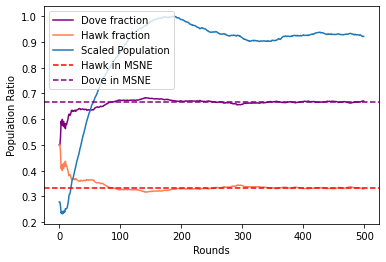

In [21]:
plt.clf()
plt.plot(npdovePer, color = "purple", label = "Dove fraction")
plt.plot(nphawkPer, color = "coral", label = "Hawk fraction")
plt.plot(nppopulation, label = "Scaled Population")
MSNE = game().findMSNE()
plt.axhline(y=MSNE[0][0],color = 'red', linestyle='--', label = "Hawk in MSNE")
plt.axhline(y=MSNE[0][1],color = 'purple', linestyle='--', label = "Dove in MSNE")
plt.legend()
plt.xlabel("Rounds")
plt.ylabel("Population Ratio")


plt.show()

In [22]:
print(MSNE)

[array([0.33333333, 0.66666667]), array([0.33333333, 0.66666667])]


In [7]:
## case 1 in ppt
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 200
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 40
MAX_FOOD_PER_ROUND = 40
MAX_FOOD_APPEARANCE = 1000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 10
ENERGY_REQUIRED_FOR_LIVING = 10


# case 3 in ppt
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 200
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 40
MAX_FOOD_PER_ROUND = 40
MAX_FOOD_APPEARANCE = 1000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 25
ENERGY_REQUIRED_FOR_LIVING = 10

# case 2 in ppt
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 200
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 40
MAX_FOOD_PER_ROUND = 40
MAX_FOOD_APPEARANCE = 1000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 20
ENERGY_REQUIRED_FOR_LIVING = 10

# case 4
STARTING_DOVES = 1000
STARTING_HAWKS = 1000
STARTING_POPULATION = STARTING_HAWKS + STARTING_DOVES

ROUNDS = 200
STARTING_ENERGY = 100

MIN_FOOD_PER_ROUND = 40
MAX_FOOD_PER_ROUND = 40
MAX_FOOD_APPEARANCE = 1000 # this tells how much max food can be found
ENERGY_REQUIRED_FOR_REPRODUCTION = 250
ENERGY_LOSS_PER_ROUND = 4
ENERGY_LOSS_FROM_FIGHTING = 60
ENERGY_REQUIRED_FOR_LIVING = 10